In [1]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False).reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
# df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
# df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = 100*(df['price-meanavge']/(df['price'] + df['meanavge']))
bins = [-43, -18, 0, 18, 43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)

k = df['price'].ewm(span=12, adjust=False, min_periods=12).mean()

# Get the 12-day EMA of the closing price
d = df['price'].ewm(span=26, adjust=False, min_periods=26).mean()

# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)

df

date         price        Volume          200D          300D  \
0    2010-09-25      0.100000           NaN           NaN           NaN   
1    2010-09-26      0.100000           NaN           NaN           NaN   
2    2010-09-27      0.100000           NaN           NaN           NaN   
3    2010-09-28      0.100000           NaN           NaN           NaN   
4    2010-09-29      0.100000           NaN           NaN           NaN   
...         ...           ...           ...           ...           ...   
4518 2023-03-07  22219.769531  2.276545e+10  19720.312564  21277.755710   
4519 2023-03-08  21718.080078  2.253658e+10  19723.208465  21253.562643   
4520 2023-03-09  20363.021484  3.036466e+10  19717.437572  21223.824715   
4521 2023-03-10  20187.244141  3.957826e+10  19711.292293  21190.847529   
4522 2023-03-11  20176.738281  3.620533e+10  19704.589984  21153.740990   

               50D      meanavge    meanvalue status  price-meanavge  \
0              NaN           NaN          NaN      0             NaN   
1              NaN           NaN          NaN      0             NaN   
2              NaN           NaN          NaN      0             NaN   
3              NaN           NaN          NaN      0             NaN   
4              NaN           NaN          NaN      0             NaN   
...            ...           ...          ...    ...             ...   
4518  23002.944336  21333.670870   886.098661      1      886.098661   
4519  23014.075547  21330.282218   387.797860      1      387.797860   
4520  23007.560352  21316.274213  -953.252729      0     -953.252729   
4521  22989.569375  21297.236399 -1109.992258      0    -1109.992258   
4522  22939.573086  21265.968020 -1089.229739      0    -1089.229739   

         move%           Valuation        macd      macd_h      macd_s  
0          NaN                 NaN         NaN         NaN         NaN  
1          NaN                 NaN         NaN         NaN         NaN  
2          NaN                 NaN         NaN         NaN         NaN  
3          NaN                 NaN         NaN         NaN         NaN  
4          NaN                 NaN         NaN         NaN         NaN  
...        ...                 ...         ...         ...         ...  
4518  2.034509  Neutral Overbought -109.950930 -237.475616  127.524686  
4519  0.900842  Neutral Overbought -194.052951 -257.262109   63.209158  
4520 -2.287113    Neutral Oversold -365.829260 -343.230735  -22.598526  
4521 -2.675681    Neutral Oversold -510.264969 -390.133155 -120.131814  
4522 -2.628278    Neutral Oversold -618.449937 -398.654499 -219.795439  

[4523 rows x 15 columns]

09:04:02 - cmdstanpy - INFO - Chain [1] start processing
09:04:15 - cmdstanpy - INFO - Chain [1] done processing


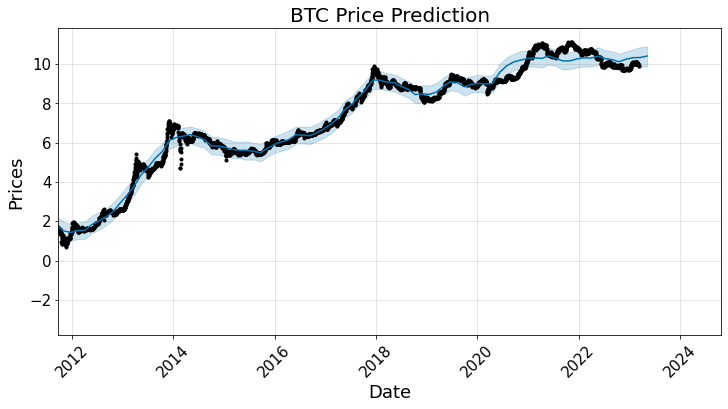

In [2]:
## Combine with Prophet
from datetime import timedelta, date
from prophet import Prophet
df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2011-09-25', '2024-10-24'])) 
plt.show();

In [3]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")
fig.layout.template = 'seaborn'	
fig.show()
fig.write_html('../static/combo.html')

In [4]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="200D", x=df['date'], y=df['200D'], marker = {'color' : 'red'}, legendrank=2))
fig.add_trace(go.Scatter(name="50D", x=df['date'], y=df['50D'], marker = {'color' : 'blue'}, legendrank=2))
fig.add_trace(go.Scatter(name="300D", x=df['date'], y=df['300D'], marker = {'color' : 'black'}, legendrank=2))
# fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
#     fill=None,
#     mode='lines',
#     line_color='lightblue',
#     ))
# fig.add_trace(go.Scatter(
#     x=prediction['ds'],
#     y=np.exp(prediction['yhat_lower']),
#     fill='tonexty', # fill area between trace0 and trace1
#     mode='lines', line_color='lightblue'))

# fig.add_trace(go.Scatter(
#     x=prediction['ds'],
#     y=np.exp(prediction['yhat_upper']),
#     fill='tonexty', # fill area between trace0 and trace1
#     mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=True)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")
fig.layout.template = 'seaborn'	
fig.show()
fig.write_html('../static/325D.html')

In [5]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Buy Zones 2.0')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=True)
fig.update_traces(dict(marker_line_width=.01))
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/buyzones2.html')

In [6]:
from datetime import date
from datetime import datetime

d1 = str(int(df.price[df['date']=='2014-01-06'].tolist()[0]/df.price[df['date']=='2011-11-25'].tolist()[0]*100)) +"%"
d2 = str(int(-100*(1-(df.price[df['date']=='2015-10-05'].tolist()[0]/df.price[df['date']=='2014-01-07'].tolist()[0])))) + "%"
d3 = str(int(df.price[df['date']=='2018-01-06'].tolist()[0]/df.price[df['date']=='2015-10-06'].tolist()[0]*100)) +"%"
d4 = str(int(-100*(1-(df.price[df['date']=='2019-03-30'].tolist()[0]/df.price[df['date']=='2018-01-07'].tolist()[0])))) + "%"
d5 = str(int(df.price[df['date']=='2021-11-08'].tolist()[0] / df.price[df['date']=='2019-04-01'].tolist()[0] *100)) + "%"
d6 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2021-11-09'].tolist()[0])))) + "%"
d7 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2023-01-14'].tolist()[0])))) + "%"

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_vrect(x0="2011-11-25", x1="2014-01-06", 
              annotation_text=str((date(2014, 2, 4)-date(2011, 11, 25)).days) + " days " + str(d1), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-01-07", x1="2015-10-05", 
              annotation_text=str((date(2015, 10, 7)-date(2014, 2, 5)).days) + " days " + str(d2), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-06", x1="2018-01-06", 
              annotation_text=str((date(2018, 1, 18)-date(2015, 10, 6)).days) +" days " + str(d3), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-01-07", x1="2019-03-30", 
              annotation_text=str((date(2019, 3, 30)-date(2018, 1, 18)).days) + " days " + str(d4), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-01", x1="2021-11-08", 
              annotation_text=str((date(2021, 11, 8)-date(2019, 4, 1)).days) + " days " + str(d5), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-09", x1=("2023-01-14"), 
              annotation_text=str((date.today() -date(2021, 11, 8)).days) + " days " + str(d6), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today() -date(2023, 1, 14)).days) + " days " + str(d7), annotation_position="left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones + Bull/Bear')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=15, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=1, line_dash="dash", line_color="black")
fig.add_vline(x='2016-07-09', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2020-05-11', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2024-04-02', line_width=1, line_dash="dash", line_color="black")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/combodates.html')

In [7]:
df['status'] = df['status'].replace({'0': 'Under'})
df['status'] = df['status'].replace({'1': 'Over'})

In [8]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Time To Reach Previous ATH')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus.html')

In [9]:
## Approximate date/time to reach previous ATH

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
# fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
# fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
# fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Cycle Tops')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-10-22", 
              annotation_text=str((date(2024, 10, 22) - date.today()).days) + " days previous ATH", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="blue", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/approximatenextath.html')

In [10]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Meanaverage')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2011-09-04", x1="2012-05-16", 
              annotation_text=str((date(2012, 5, 16)-date(2011, 9, 4)).days) + " days", annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2012-05-17", x1="2014-02-10", 
              annotation_text=str((date(2014, 2, 10)-date(2012, 5, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-02-11", x1="2015-10-06", 
              annotation_text=str((date(2015, 10, 6)-date(2014, 2, 11)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-07", x1="2018-02-18", 
              annotation_text=str((date(2018, 2, 18)-date(2015, 10, 7)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-02-19", x1="2019-04-02", 
              annotation_text=str((date(2019, 4, 2)-date(2018, 2, 19)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-03", x1="2021-11-07", 
              annotation_text=str((date(2021, 11, 7)-date(2019, 4, 3)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=("2023-01-14"), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2023, 1, 14)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
# fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
#               annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
#               annotation=dict(font_size=15, font_family="Times New Roman"),
#               fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="top center"
))
        

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus2.html')

In [11]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Under vs Over')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.update_traces(dict(marker_line_width=.01))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/overunder.html')

In [12]:
df['rateofchangemove%'] = df['move%'].diff()


In [13]:
df_tail=df.dropna()
df_tail = df_tail.tail(90)
df_tail.head()

date         price        Volume          200D          300D  \
4433 2022-12-12  17206.437500  1.961758e+10  20890.839336  26886.478557   
4434 2022-12-13  17781.318359  2.663474e+10  20836.739928  26799.470952   
4435 2022-12-14  17815.650391  2.553448e+10  20780.682680  26723.680453   
4436 2022-12-15  17364.865234  2.096445e+10  20720.181006  26648.229671   
4437 2022-12-16  16647.484375  2.403161e+10  20644.801928  26570.086952   

               50D      meanavge    meanvalue status  price-meanavge  \
4433  17916.869344  21898.062412 -4691.624912  Under    -4691.624912   
4434  17885.865711  21840.692197 -4059.373837  Under    -4059.373837   
4435  17840.716719  21781.693284 -3966.042893  Under    -3966.042893   
4436  17772.605195  21713.671957 -4348.806723  Under    -4348.806723   
4437  17699.838164  21638.242348 -4990.757973  Under    -4990.757973   

          move%         Valuation       macd      macd_h      macd_s  \
4433 -11.997660  Neutral Oversold -90.207136  121.444142 -211.651278   
4434 -10.245249  Neutral Oversold -24.452817  149.758769 -174.211586   
4435 -10.015932  Neutral Oversold  30.081502  163.434470 -133.352968   
4436 -11.128376  Neutral Oversold  36.504941  135.886327  -99.381386   
4437 -13.035558  Neutral Oversold -16.105424   66.620770  -82.726194   

        priceL  rateofchangemove%  
4433  9.753039           0.442076  
4434  9.785904           1.752410  
4435  9.787833           0.229318  
4436  9.762204          -1.112445  
4437  9.720014          -1.907181

In [14]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [15]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [16]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [17]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.1, 0.03,0.03,0.03])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=600, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [18]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=800, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [19]:
btccandle = yf.download('BTC-USD')
btccandle = btccandle.reset_index()
btccandle

[*********************100%***********************]  1 of 1 completed


Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
3092 2023-03-06  22436.816406  22584.292969  22331.314453  22429.757812   
3093 2023-03-07  22428.322266  22527.417969  22011.261719  22219.769531   
3094 2023-03-08  22216.441406  22268.896484  21708.050781  21718.080078   
3095 2023-03-09  21720.080078  21802.716797  20210.306641  20363.021484   
3096 2023-03-10  20367.001953  20370.595703  19628.253906  20187.244141   

         Adj Close       Volume  
0       457.334015     21056800  
1       424.440002     34483200  
2       394.795990     37919700  
3       408.903992     36863600  
4       398.821014     26580100  
...            ...          ...  
3092  22429.757812  17353192895  
3093  22219.769531  22765452204  
3094  21718.080078  22536575684  
3095  20363.021484  30364664171  
3096  20187.244141  39578257695  

[3097 rows x 7 columns]

In [20]:
df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False)
df

Open          High           Low         Close  \
Date                                                                 
2016-03-11    417.238007    423.925995    417.013000    421.690002   
2016-03-12    421.605011    421.795013    410.093994    411.623993   
2016-03-13    411.648010    416.604004    411.641998    414.065002   
2016-03-14    414.200989    416.683990    414.200989    416.437988   
2016-03-15    416.388000    418.131012    414.984985    416.829987   
...                  ...           ...           ...           ...   
2023-03-07  22428.322266  22527.417969  22011.261719  22219.769531   
2023-03-08  22216.441406  22268.896484  21708.050781  21718.080078   
2023-03-09  21720.080078  21802.716797  20210.306641  20363.021484   
2023-03-10  20367.001953  20370.595703  19628.253906  20187.244141   
2023-03-11  20203.859375  20792.525391  20069.201172  20189.236328   

                 Volume  
Date                     
2016-03-11     73969696  
2016-03-12     92712896  
2016-03-13     74322800  
2016-03-14     95259400  
2016-03-15     66781700  
...                 ...  
2023-03-07  22765452204  
2023-03-08  22536575684  
2023-03-09  30364664171  
2023-03-10  39578257695  
2023-03-11  36115808256  

[2557 rows x 5 columns]